# 1. Configuration, Imports et Chargement des Données


In [1]:
import arviz as az
import numpy as np
import pandas as pd
import pymc as pm
import pytensor
from matplotlib import pyplot as plt
from pymc.distributions.timeseries import GaussianRandomWalk 
from pytensor import tensor as T
import warnings

# --- CONFIGURATION ---
RANDOM_SEED = 8927
rng = np.random.default_rng(RANDOM_SEED)
az.style.use("arviz-darkgrid")
n_samples = 1000
n_tune = 1000

# Supprimer certaines alertes de sampling pour un affichage plus propre
warnings.filterwarnings('ignore', category=UserWarning, message='Found a random variable that was neither among the observations nor the conditioned variables')
print(f"Running on PyMC v{pm.__version__}")


# --- CHARGEMENT ET PRÉPARATION DES DONNÉES ---
try:
    # PyMC utilise get_data pour récupérer les jeux de données des exemples
    df = pd.read_csv(pm.get_data("mastectomy.csv"))
except Exception as e:
    print(f"Erreur de chargement. Vérifiez l'accès. Erreur: {e}")
    raise

# Préparation des colonnes
df.event = df.event.astype(np.int64)
# 'yes' devient 1, 'no' devient 0
df.metastasized = (df.metastasized == "yes").astype(np.int64) 

n_patients = df.shape[0]
patients = np.arange(n_patients)

print("\nAperçu des données:")
print(df.head())

Running on PyMC v5.26.1

Aperçu des données:
   time  event  metastasized
0    23      1             0
1    47      1             0
2    69      1             0
3    70      0             0
4   100      0             0


# 2. Préparation du Modèle Poisson et Visualisation des Durées


Nombre d'intervalles de temps (lambda0): 76


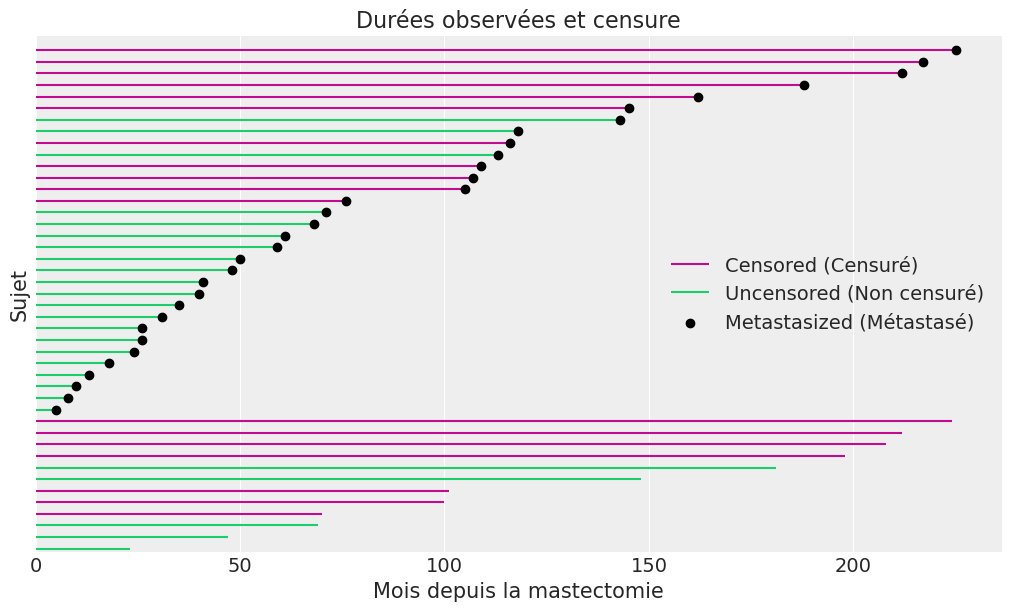

In [2]:
# --- PRÉ-TRAITEMENT POUR L'APPROXIMATION POISSON ---
# Définir les intervalles de temps pour le modèle d'aléa par morceaux
interval_length = 3 # Durée de l'intervalle en mois
interval_bounds = np.arange(0, df.time.max() + interval_length + 1, interval_length)
n_intervals = interval_bounds.size - 1
intervals = np.arange(n_intervals)

# 1. Variable indicatrice 'death' (d_i,j)
last_period = np.floor((df.time - 0.01) / interval_length).astype(int)
death = np.zeros((n_patients, n_intervals))
# La mort (df.event == 1) est enregistrée dans le dernier intervalle atteint (last_period)
death[patients, last_period] = df.event 

# 2. Temps à risque 'exposure' (t_i,j)
exposure = np.greater_equal.outer(df.time.to_numpy(), interval_bounds[:-1]) * interval_length
# Pour l'intervalle final, l'exposition est le temps écoulé depuis le début de cet intervalle
exposure[patients, last_period] = df.time - interval_bounds[last_period]

print(f"Nombre d'intervalles de temps (lambda0): {n_intervals}")


# --- VISUALISATION DES DONNÉES BRUTES ET CENSURE ---
fig, ax = plt.subplots(figsize=(10, 6))
ax.hlines(
    patients[df.event.values == 0],
    0,
    df[df.event.values == 0].time,
    color="C3",
    label="Censored (Censuré)",
)
ax.hlines(
    patients[df.event.values == 1],
    0,
    df[df.event.values == 1].time,
    color="C7",
    label="Uncensored (Non censuré)",
)
ax.scatter(
    df[df.metastasized.values == 1].time,
    patients[df.metastasized.values == 1],
    color="k",
    zorder=10,
    label="Metastasized (Métastasé)",
)
ax.set_xlim(left=0)
ax.set_xlabel("Mois depuis la mastectomie")
ax.set_yticks([])
ax.set_ylabel("Sujet")
ax.set_ylim(-0.25, n_patients + 0.25)
ax.legend(loc="center right")
plt.title("Durées observées et censure")
plt.show()

# 3. Modèle 1 : Aléas Proportionnels (Beta Constant) et Inférence

Initializing NUTS using jitter+adapt_diag...


--- 1. MODÈLE D'ALÉAS PROPORTIONNELS (BÊTA CONSTANT) ---
Échantillonnage du Modèle 1...


/Users/jordan/miniconda3/envs/general/lib/python3.11/site-packages/pytensor/link/c/cmodule.py:3004: UserWarning: PyTensor could not link to a BLAS installation. Operations that might benefit from BLAS will be severely degraded.
This usually happens when PyTensor is installed via pip. We recommend it be installed via conda/mamba/pixi instead.
Alternatively, you can use an experimental backend such as Numba or JAX that perform their own BLAS optimizations, by setting `pytensor.config.mode == 'NUMBA'` or passing `mode='NUMBA'` when compiling a PyTensor function.
For more options and details see https://pytensor.readthedocs.io/en/latest/troubleshooting.html#how-do-i-configure-test-my-blas-library
  warnings.warn(
Sequential sampling (2 chains in 1 job)
NUTS: [lambda0, beta]


Output()

Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 263 seconds.
There were 82 divergences after tuning. Increase `target_accept` or reparameterize.
We recommend running at least 4 chains for robust computation of convergence diagnostics
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details



Ratio d'aléa moyen (exp(beta)) : 2.5172


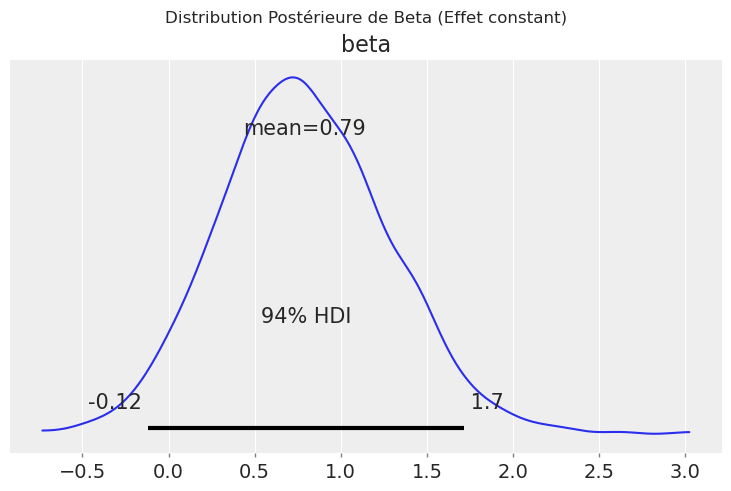

In [3]:
# --- MODÈLE D'ALÉAS PROPORTIONNELS BAYÉSIEN (BÊTA CONSTANT) ---
print("--- 1. MODÈLE D'ALÉAS PROPORTIONNELS (BÊTA CONSTANT) ---")

coords = {"intervals": intervals}
with pm.Model(coords=coords) as model:
    # Aléa de base (lambda0) - constant par morceaux, Gamma vague
    lambda0 = pm.Gamma("lambda0", 0.01, 0.01, dims="intervals")
    
    # Coefficient de régression (beta) - effet constant sur le temps, Normal vague
    beta = pm.Normal("beta", 0, sigma=1000)
    
    # Taux d'aléa spécifique au sujet : lambda_i,j = lambda_j * exp(x_i * beta)
    lambda_ = pm.Deterministic("lambda_", T.outer(T.exp(beta * df.metastasized), lambda0))
    
    # Moyenne pour Poisson : mu_i,j = t_i,j * lambda_i,j (exposition * aléa)
    mu = pm.Deterministic("mu", exposure * lambda_)
    
    # Vraisemblance (Approximation de Poisson)
    obs = pm.Poisson("obs", mu, observed=death)
    
    # Échantillonnage MCMC
    print("Échantillonnage du Modèle 1...")
    idata = pm.sample(
        n_samples,
        tune=n_tune,
        target_accept=0.99,
        random_seed=RANDOM_SEED,
        cores=1 # Utiliser 1 pour la simplicité de l'environnement Notebook
    )

# Analyse des résultats clés
hazard_ratio = np.exp(idata.posterior["beta"]).mean().item()
print(f"\nRatio d'aléa moyen (exp(beta)) : {hazard_ratio:.4f}")

az.plot_posterior(idata, var_names=["beta"])
plt.suptitle("Distribution Postérieure de Beta (Effet constant)")
plt.show()

# 4. Visualisation de l'Aléa et de la Survie (Modèle 1)


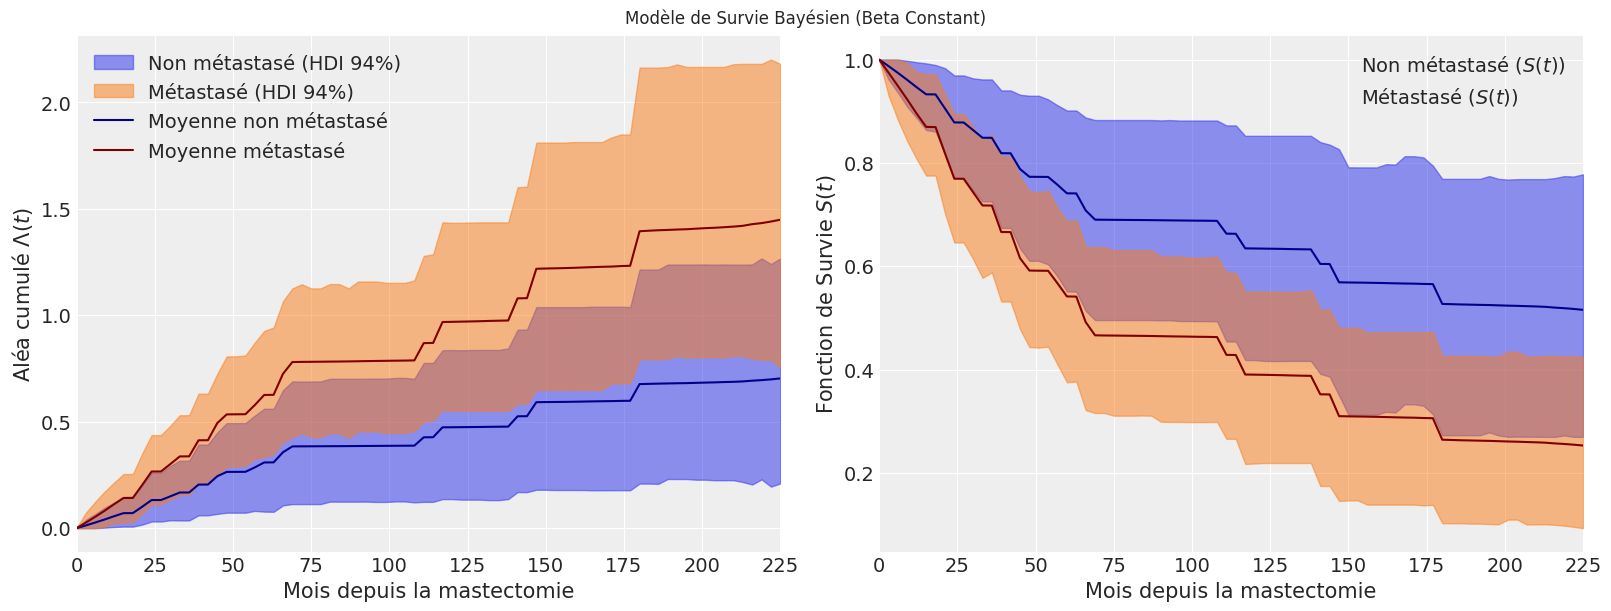

In [15]:
# --- TRACÉS ALÉA CUMULÉ ET SURVIE (MODÈLE 1) ---

# Définition des fonctions pour le calcul
base_hazard = idata.posterior["lambda0"]
met_hazard = idata.posterior["lambda0"] * np.exp(idata.posterior["beta"])

def cum_hazard(hazard):
    # Aléa cumulé = somme des (aléa * durée d'intervalle)
    return (interval_length * hazard).cumsum(axis=-1)

def survival(hazard):
    # Fonction de survie S(t) = exp(-Lambda(t))
    return np.exp(-cum_hazard(hazard))

def get_mean(trace):
    return trace.mean(("chain", "draw"))

fig, (hazard_ax, surv_ax) = plt.subplots(ncols=2, sharex=True, figsize=(16, 6))

# Tracé de l'Aléa Cumulé
az.plot_hdi(
    interval_bounds[:-1],
    cum_hazard(base_hazard),
    ax=hazard_ax,
    smooth=False,
    color="C0",
    fill_kwargs={"label": "Non métastasé (HDI 94%)"},
)
az.plot_hdi(
    interval_bounds[:-1],
    cum_hazard(met_hazard),
    ax=hazard_ax,
    smooth=False,
    color="C1",
    fill_kwargs={"label": "Métastasé (HDI 94%)"},
)
hazard_ax.plot(interval_bounds[:-1], get_mean(cum_hazard(base_hazard)), color="darkblue", label="Moyenne non métastasé")
hazard_ax.plot(interval_bounds[:-1], get_mean(cum_hazard(met_hazard)), color="maroon", label="Moyenne métastasé")
hazard_ax.set_xlim(0, df.time.max())
hazard_ax.set_xlabel("Mois depuis la mastectomie")
hazard_ax.set_ylabel(r"Aléa cumulé $\Lambda(t)$")
hazard_ax.legend(loc=2)

# Tracé de la Fonction de Survie
az.plot_hdi(interval_bounds[:-1], survival(base_hazard), ax=surv_ax, smooth=False, color="C0")
az.plot_hdi(interval_bounds[:-1], survival(met_hazard), ax=surv_ax, smooth=False, color="C1")
surv_ax.plot(interval_bounds[:-1], get_mean(survival(base_hazard)), color="darkblue")
surv_ax.plot(interval_bounds[:-1], get_mean(survival(met_hazard)), color="maroon")
surv_ax.set_xlim(0, df.time.max())
surv_ax.set_xlabel("Mois depuis la mastectomie")
surv_ax.set_ylabel(r"Fonction de Survie $S(t)$")
surv_ax.legend([r"Non métastasé ($S(t)$)", r"Métastasé ($S(t)$)"], loc=1)
fig.suptitle("Modèle de Survie Bayésien (Beta Constant)");
plt.show()

# 5. Modèle 2 : Beta variant dans le temps et Visualisation du Ratio d'Aléa


Initializing NUTS using jitter+adapt_diag...


--- 2. MODÈLE D'ALÉAS PROPORTIONNELS (BÊTA VARIANT DANS LE TEMPS) ---
Échantillonnage du Modèle 2...


Sequential sampling (2 chains in 1 job)
NUTS: [lambda0, beta]


/Users/jordan/miniconda3/lib/python3.11/site-packages/rich/live.py:256: UserWarning: install "ipywidgets" for 
Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 392 seconds.
There were 112 divergences after tuning. Increase `target_accept` or reparameterize.
Chain 0 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 1 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
We recommend running at least 4 chains for robust computation of convergence diagnostics
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


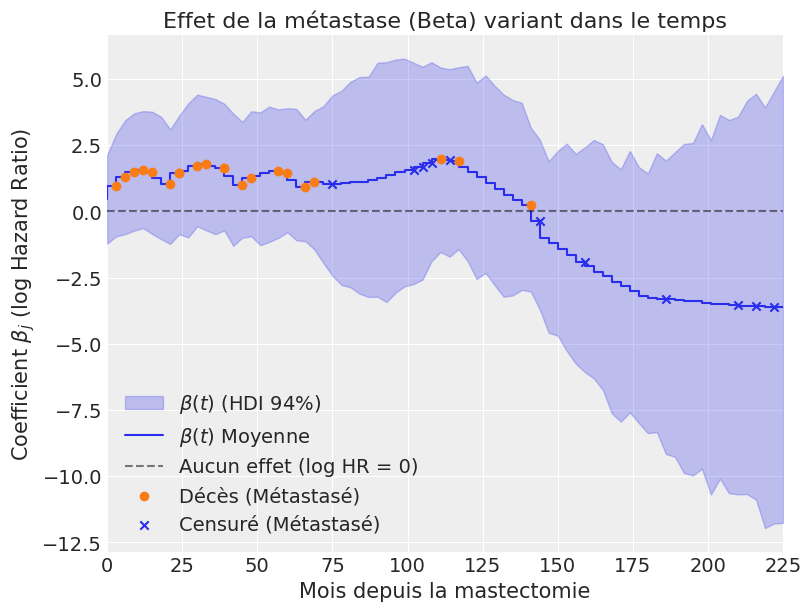

In [21]:
# --- MODÈLE D'ALÉAS PROPORTIONNELS (BÊTA VARIANT DANS LE TEMPS) ---
print("--- 2. MODÈLE D'ALÉAS PROPORTIONNELS (BÊTA VARIANT DANS LE TEMPS) ---")

coords = {"intervals": intervals}
with pm.Model(coords=coords) as time_varying_model:
    # Aléa de base (lambda0) - constant par morceaux, Gamma vague
    lambda0 = pm.Gamma("lambda0", 0.01, 0.01, dims="intervals")
    
    # Coefficient de régression (beta) - modélisé comme une Marche Aléatoire Gaussienne
    beta = GaussianRandomWalk("beta", init_dist=pm.Normal.dist(), sigma=1.0, dims="intervals")
    
    # Taux d'aléa spécifique au sujet : lambda_i,j = lambda_j * exp(x_i * beta_j)
    lambda_ = pm.Deterministic("h", lambda0 * T.exp(T.outer(T.constant(df.metastasized), beta)))
    
    # Moyenne pour Poisson
    mu = pm.Deterministic("mu", exposure * lambda_)
    
    # Vraisemblance (Approximation de Poisson)
    obs = pm.Poisson("obs", mu, observed=death)

    # Échantillonnage MCMC
    print("Échantillonnage du Modèle 2...")
    time_varying_idata = pm.sample(
        n_samples,
        tune=n_tune,
        return_inferencedata=True,
        target_accept=0.99,
        random_seed=RANDOM_SEED,
        cores=1
    )

# --- TRACÉ DU COEFFICIENT BETA (log-Hazard Ratio) ---
fig, ax = plt.subplots(figsize=(8, 6))

# Calcul de l'intervalle de crédibilité (HDI à 94%) pour beta
az.plot_hdi(
    interval_bounds[:-1],
    time_varying_idata.posterior["beta"],
    ax=ax,
    smooth=False, # az.plot_hdi gère à la fois la moyenne et l'intervalle
    color="C0",
    fill_kwargs={"alpha": 0.25, "label": r"$\beta(t)$ (HDI 94%)"}
)

# Récupération de la moyenne postérieure pour le tracé de la ligne
beta_hat = time_varying_idata.posterior["beta"].mean(("chain", "draw"))
ax.step(interval_bounds[:-1], beta_hat, color="C0", where='pre', label=r"$\beta(t)$ Moyenne")

# Ligne de référence à 0 (log(1) = 0, signifiant aucun effet)
ax.axhline(0, color='k', linestyle='--', alpha=0.5, label="Aucun effet (log HR = 0)")

# Ajout des points d'observation (Métastasés)
# Patients métastasés ET décédés (événement=1)
ax.scatter(
    interval_bounds[last_period[(df.event.values == 1) & (df.metastasized == 1)]],
    beta_hat.isel(intervals=last_period[(df.event.values == 1) & (df.metastasized == 1)]),
    color="C1",
    marker='o',
    zorder=10,
    label="Décès (Métastasé)",
)

# Patients métastasés ET censurés (événement=0)
ax.scatter(
    interval_bounds[last_period[(df.event.values == 0) & (df.metastasized == 1)]],
    beta_hat.isel(intervals=last_period[(df.event.values == 0) & (df.metastasized == 1)]),
    color="C0",
    marker='x',
    zorder=10,
    label="Censuré (Métastasé)",
)

ax.set_xlim(0, df.time.max())
ax.set_xlabel("Mois depuis la mastectomie")
ax.set_ylabel(r"Coefficient $\beta_j$ (log Hazard Ratio)")
ax.legend()
plt.title("Effet de la métastase (Beta) variant dans le temps")
plt.show()